### 1. 라이브러리 호출

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.nn.functional as F 

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

### 2. CPU 혹은 GPU 장치 확인

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
torch.cuda.is_available()

True

In [6]:
# # *GPU 사용
# ## 하나의 GPU 사용 시
# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # model = Net()
# # model.to(device)

# ## 다수의 GPU 사용 시 nn.DataParallel
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Net()
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(net)
# model.to(device)

# ## nn.DataParallel을 사용할 경우 batch size가 알아서 각 GPU로 분배되는 방식으로 작동. 따라서 GPU 수만큼 배치 크기도 늘려주어야 함.



### 3. fashion_mnist 데이터셋 내려받기

In [7]:
train_dataset = torchvision.datasets.FashionMNIST("/home/hb/python/pytorch_book/080289/chap05/data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/home/hb/python/pytorch_book/080289/chap05/data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))


### 4. fashion_mnist 데이터를 데이터로더에 전달


In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

### 5. 분류에 사용될 클래스 정의

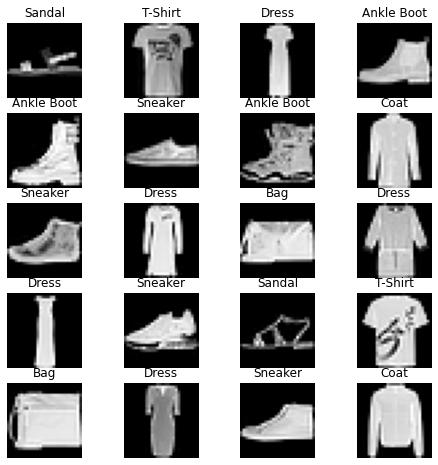

In [9]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'} # 열 개의 클래스

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset)); # 1
    img = train_dataset[img_xy][0][0,:,:] # 2
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

1. `np.random`은 무작위로 데이터를 생성할 때 사용합니다.
    또한, `np.random.randient()`는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용합니다. 따라서 `random.randint(len(train_dataset))` 의미는 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미입니다. 참고로 `random.randint`와 유사하게 사용되는 `random.rand`와 `random.randn`을 예시로 살펴보겠습니다.

2. train_dataset을 이용한 3차원 배열을 생성합니다.

### 6. 심층 신경망 모델 생성

In [10]:
class FashionDNN(nn.Module):
    def __init__(self): # 1
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256) # 2
        self.drop = nn.Dropout(0.25) # 3
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self, input_data): # 4
        out = input_data.view(-1, 784) # 5
        out = F.relu(self.fc1(out)) # 6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

1. class 형태의 모델은 항상 `torch.nn.Module` 을 상속받습니다. `__init__()`은 객체가 갖는 속성 값을 초기화하는 역할을 하며, 객체가 생성될 때 자동으로 호출됩니다. `super(FashionDNN, self).__init__()`은 FashionDNN이라는 부모(super) 클래스를 상속받겠다는 의미로 이해하면 됩니다.

2. nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 때 사용합니다. 이때 사용되는 파라미터는 다음과 같습니다.
- `nn.Linear(in_features=784, out_features=256)`
    - in_features : 입력의 크기(input size)
    - out_features : 출력의 크기(output size)
실제로 데이터 연산이 진행되는 `forward()` 부분에는 첫 번째 파라미터 값만 넘겨주게 되며, 두 번째 파라미터에서 정의된 크기가 `forward()` 연산의 결과가 됩니다.

3. `torch.nn.Dropout(p)`는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커집니다. 예를 들어 p=0.3 이라는 의미는 전체 값 중 0.3의 확률로 0이 된다는 것이며, 0이 되지 않는 0.7에 해당하는 값은 (1/(1-0.7))만큼 커집니다.

4. `forward()` 함수는 모델이 학습 데이터를 입력받아서 순전파(forward propagation) 학습을 진행시키며, 반드시 forward라는 이름의 함수여야 합니다. 즉, `forward()` 는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행됩니다. 이때 순전파 연산이란 H(x)^2 식에 입력 x로부터 예측된 y를 얻는 것입니다.

5. 파이토치에서 사용하는 뷰(`view`)는 넘파이의 `reshape` 과 같은 역할로 텐서의 크기(shape)를 변경해 주는 역할을 합니다. 따라서 `input_data.view(-1, 784)`는 input_data를 (?, 784)의 크기로 변경하라는 의미입니다. 이때 첫 번째 차원(-1)은 사용자가 잘 모르겠으니 파이토치에 맡기겠다는 의미이고, 두 번째 차원의 길이는 784를 가지도록 하라는 의미입니다. 다시 말해 2차원 텐서로 변경하되 (?, 84)의 크기로 변경하라는 의미입니다.

6. 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능합니다.
- `F.relu()`: `forward()` 함수에서 정의
- `nn.ReLU()`: `__init__()` 함수에서 정의

활성화 함수 사용에 한정하여 이 둘 간의 차이는 간단히 사용하는 위치라고 할 수 있습니다. 하지만 근본적으로는 `nn.functional.xx()` (혹은 `F.xx()`)와 `nn.xx()`는 사용 방법에 차이가 있습니다. 다음 코드를 통해 둘 간의 차이를 확인할 수 있습니다.

먼저 `nn`을 사용하는 코드는 다음과 같습니다.

In [11]:
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1,1,3)
print(outputs)
print(layer)

tensor([[[[-1.5161e-01, -7.1167e-02, -3.4763e-01,  ...,  3.6414e-01,
           -2.1670e-01, -3.4332e-01],
          [ 1.0205e+00, -1.7987e-01, -9.4854e-02,  ...,  7.4106e-01,
           -1.3184e+00, -1.1144e+00],
          [-5.2409e-01,  2.0276e-02, -5.7628e-02,  ..., -7.3177e-02,
            8.5032e-01, -9.2529e-01],
          ...,
          [-7.4550e-01, -8.4447e-01,  7.3173e-01,  ...,  7.8713e-01,
           -2.3932e-01,  7.2957e-01],
          [-3.9846e-01, -1.2885e+00,  8.6326e-02,  ...,  1.5638e+00,
           -5.0422e-02, -6.6568e-01],
          [-5.0005e-01,  1.1146e+00,  5.0773e-01,  ..., -2.9931e-01,
            4.1592e-01, -1.5325e+00]],

         [[-1.5822e-01,  1.2689e-01,  7.9417e-01,  ...,  2.2443e-01,
           -2.1173e-01,  2.8445e-01],
          [-1.5553e-01,  1.2127e+00,  7.7106e-01,  ...,  3.5354e-01,
           -5.8724e-01, -8.7505e-02],
          [-5.8903e-01,  1.0361e+00,  1.5025e-01,  ...,  8.7604e-01,
           -4.0044e-01,  6.1323e-01],
          ...,
     

In [12]:
import torch.nn.functional as F 

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3 , 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)


In [13]:
# 5-7 : 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# 5-8 : 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = [] # 1
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: # 2
        images, labels = images.to(device), labels.to(device) # 3

        train = Variable(images.view(100, 1, 28, 28)) # 4
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total # 5
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
                

Iteration: 500, Loss: 0.6050916910171509, Accuracy: 83.33999633789062%
Iteration: 1000, Loss: 0.49987518787384033, Accuracy: 84.91999816894531%
Iteration: 1500, Loss: 0.3403399586677551, Accuracy: 84.97000122070312%
Iteration: 2000, Loss: 0.3703915476799011, Accuracy: 85.0%
Iteration: 2500, Loss: 0.26292020082473755, Accuracy: 85.69999694824219%
Iteration: 3000, Loss: 0.29145416617393494, Accuracy: 86.8699951171875%


1. 비어 있는 배열이나 행렬을 만듭니다.
2. for 구문을 사용하여 레코드(행, 가로줄)를 하나씩 가져옵니다. 이때 `for x, y in train:` 과 같이 in 앞에 변수를 두 개 지정해 주면 레코드에서 요소 두 개를 꺼내 오겠다는 의미입니다.
3. 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치(CPU 또는 GPU에 있어야 합니다. 코드 5-7에서 `model.to(device)`가 GPU를 사용했다면, `images.to(device), labels.to(device)`도 GPU에서 처리되어야 합니다. 참고로 CPU에서 처리된 데이터를 GPU 모델에 적용하거나 그 반대의 경우 런타임 오류가 발생합니다.
4. Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해 테이프(tape)를 사용합니다. 순전파(forward) 단계에서 테이프는 수행하는 모든 연산을 저장합니다. 
    
    그리고 역전파(backward) 단계에서 저장된 값들을 꺼내서 사용합니다. 즉, Autograd는 `Variable`을  사용해서 역전파를 위한 미분 값을 자동으로 계산해 줍니다. 따라서 자동 미분을 계산하기 위해서는`torch.autograd` 패키지 안에 있는 `Variable` 을 이용해야 동작합니다.



In [15]:
# 5-9 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( #1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #2 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) #4
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

        def forward(self,x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.view(out.size(0), -1) # 6
            out = self.fc1(out)
            out = self.drop(out)
            out = self.fc2(out)
            out = self.fc3(out)
            return out

1. `nn.Sequential`을 사용하면 `__init__()`에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라, `forward()` 함수에서 구현될 순전파를 계층(layer) 형태로 좀 더 가독성이 뛰어난 코드로 작성할 수 있습니다. 즉, `nn.Sequential`은 계층을 차례로 쌓을 수 있도록 Wx+b와 같은 수식과 활성화 함수를 연결해 주는 역할을 합니다. 특히 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋은 방법입니다. 정리하면 `nn.Sequential`은 여러 개의 계층을 하나의 컨테이너에 구현하는 방법이라고 생각하면 됩니다.

2. 합성곱층(conv layer)은 합성곱 연산을 통해서 이미지의 특징을 추출합니다. 합성곱이란 커널(또는 필터)이라는 nxm크기의 행렬이 높이(height) x 너비(width) 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력합니다. 커널은 일반적으로 3x3이나 5x5를 사용하며 파라미터는 다음과 같습니다.  
- `nn.Conv2d(id_channels=1, out_channels=32, kernel_size=3, padding=1)`
    - a. `in_channels`: 입력 채널의 수, 흑백 이미지는 1, RGB 값을 가진 이미지는 3을 가진 경우가 많습니다. 
    - b. `out_channels` : 출력 채널의 수
    - c. `kernel_size` : 커널 크기를 의미하며 논문에 따라 필터라고도 합니다. 커널은 이미지 특징을 찾아내기 위한 공용 파라미터이며, CNN에서 학습 대상은 필터 파라미터가 됩니다. 커널은 입력 데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산합니다.
    - d. `padding` : 패딩 크기를 의미하는 것으로 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채웁니다. 패딩 값이 클수록 출력 크기도 커집니다.

3. `BatchNorm2d` : 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라고 평균과 분산을 이용하여 정규화하는 것을 의미합니다. 입력 값의 분포가 모두 다르지만 정규화를 통해 분포를 가우시안 형태로 만듭니다. 그러면 평균은 0, 표준편차는 1로 데이터의 분포가 조정됩니다.

4. `MaxPool2d` : 이미지 크기를 축소시키는 용도로 사용합니다. 풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터(activation map)의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용됩니다. 풀링 계층을 처리하는 방법으로는 최대 풀링(max pooling)과 평균 풀링(average pooling), 최소 풀링(min pooling)이 있으며, 이때 사용하는 파라미터는 다음과 같습니다.  
- `nn.MaxPool2d(kernel_size=2, stride=2)`  
    - a. `kernel_size` : mxn 행렬로 구성된 가중치  
     - b. `stride` : 입력 데이터에 커널(필터)을 적용할 때 이동할 간격을 의미하는데, 스트라이드 값이 커지면 출력 크기는 작아집니다.
 
5. 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야 합니다. 이때 `Conv2d`에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기(output size)가 달라집니다. 즉, 패딩과 스트라이드의 값에 따라 출력 크기가 달라집니다. 이렇게 줄어든 출력 크기는 최종적으로 분류를 담당하는 완전연결층(fully connected layer)으로 전달됩니다.  
- `nn.Linear(in_features=64*6*6, out_features=600)`  
    - a. `in_features` : 입력 데이터의 크기를 의미합니다. 중요한 것은 이전까지 수행했던 `Conv2d`, `MaxPool2d`는 이미지 데이터를 입력으로 받아 처리했습니다. 하지만 그 출력 결과를 완전연결층으로 보내기 위해서는 1차원으로 변경해 주어야 하는데, 공식은 다음과 같습니다. 공식은 `Conv2d`와 `MaxPool2d`가 다르기 때문에 매 계층을 따라가면서 계산해 보기 바랍니다.
    - b. 합성곱층에서 완전연결층으로 변경되기 떄문에 데이터의 형태를 1차원으로 바꾸어 줍니다.

    이때 `out.size(0)`는 결국 64*6*6을 의미합니다. 따라서 (64*6*6, ?) 크기의 텐서로 변경하겠다는 의미입니다. `out.view(out.size(0), -1)`에서 '-1'은 행(row)의 수는 정확히 알고 있지만 열(column)의 수를 알지 못할 때 사용합니다.

### 10. 합성곱 네트워크를 위한 파라미터 정의
이번에는 합성곱 네트워크를 사용하기 위한 파라미터를 정의합니다.


In [19]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### 11. 모델 학습 및 성능 평가

In [20]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.560030460357666, Accuracy: 83.57999420166016%
Iteration: 1000, Loss: 0.44158440828323364, Accuracy: 84.8499984741211%
Iteration: 1500, Loss: 0.3901122808456421, Accuracy: 83.77999877929688%
Iteration: 2000, Loss: 0.4059669077396393, Accuracy: 85.0%
Iteration: 2500, Loss: 0.2728206515312195, Accuracy: 86.0%
Iteration: 3000, Loss: 0.2932349145412445, Accuracy: 86.61000061035156%


## 5.3 전이 학습
일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요합니다. 그런데 불행히도 충분히 큰 데이터셋을 얻는 것은 쉽지 않습니다. 큰 데이터셋을 확보하려면 많은 돈과 시간이 필요하기 때문입니다.

이러한 현실적인 어려움을 해결한 것이 전이 학습(transfer learning)입니다. 전이 학습이란 이미지넷(ImageNet)처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미합니다. 이때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 훈련된 모델(네트워크)이라고 합니다. 결과적으로 비교적 적은 수의 데이터를 가지고도 우리가 원하는 과제를 해결할 수 있습니다.

- [문제A] -(해결)-> [문제A를 해결하면서 얻은 지식 및 경험] -(적용:전이 학습)-> [문제B]

전이 학습을 위한 방법으로는 특성 추출과 미세 조정 기법이 있습니다. 특성 추출 기법부터 하나씩 살펴보겠습니다.

### 5.3.1 특성 추출 기법
특성 추출(feature extractor)은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듭니다. 즉, 학습할 때는 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 합니다.

특성 추출은 이미지 분류를 위해 두 부분으로 구성됩니다.
- 합성곱층 : 합성곱층과 풀링층으로 구성
- 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분  
사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킵니다.  
여기에서 사용 가능한 이미지 분류 모델은 다음과 같습니다.
    - Xception
    - Inception V3
    - ResNet50
    - VGG16
    - VGG19
    - MobileNet

#### 5-12 라이브러리 호출

In [21]:
!pip install opencv-python

In [22]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [23]:
data_path = '/home/hb/python/pytorch_book/080289/chap05/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 32, num_workers = 8, shuffle = True
)

print(len(train_dataset))

385


#### 5-14 학습에 사용될 이미지 출력

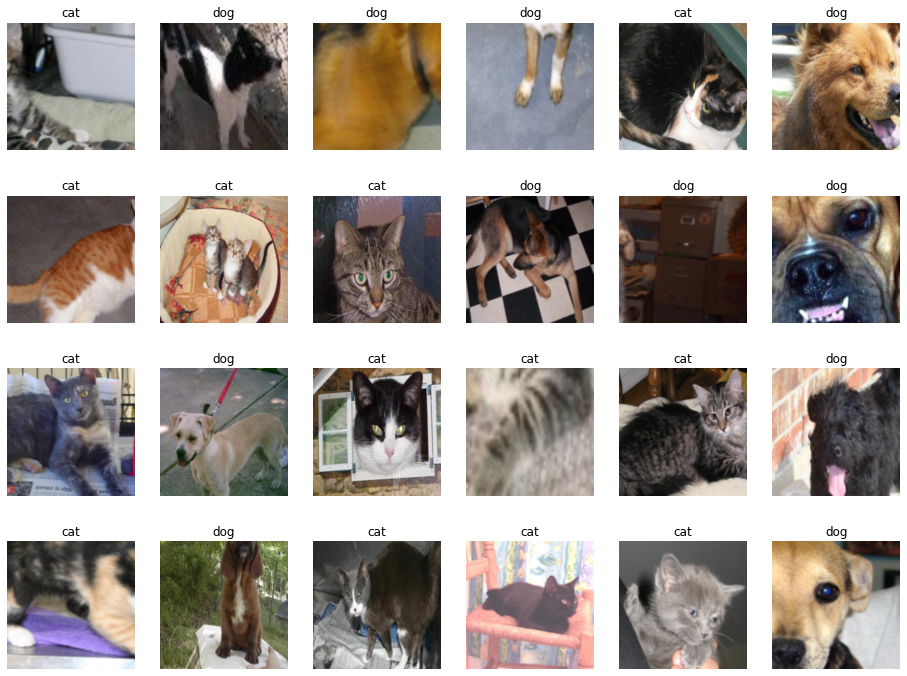

In [25]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

#### 5-15. 사전 훈련된 모델 내려받기

In [26]:
resnet18 = models.resnet18(pretrained=True)

#### 5-16. 사전 훈련된 모델의 파라미터 학습 유무 지정
다음은 내려받은 ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정시킵니다.

In [27]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 1

set_parameter_requires_grad(resnet18)

1. 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음을 나타냅니다. 즉, 모델의 일부를 고정하고 나머지를 학습하고자 할 때 `requires_grad = False`로 설정합니다. 이때 모델의 일부는 합성곱층(convolutional layer)과 풀링(pooling)층을 의미합니다.   
내려받은 ResNet18의 마지막 부분에 완전연결층을 추가합니다. 추가된 완전연결층은 개와 고양이 클래스를 분류하는 용도로 사용됩니다.

#### 5-17. ResNet18에 완전연결층 추가

In [28]:
resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 두 개라는 의미

참고용으로 모델의 파라미터 값들을 확인해 보겠습니다.

#### 5-18. 모델의 파라미터 값 확인

In [29]:
for name, param in resnet18.named_parameters(): # mode.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0383, -0.0336, -0.0313,  ..., -0.0257,  0.0157, -0.0068],
        [ 0.0344, -0.0162, -0.0276,  ..., -0.0135, -0.0232,  0.0246]])
fc.bias tensor([0.0233, 0.0211])


#### 5-19. 모델 객체 생성 및 손실 함수 정의

In [30]:
model = models.resnet18(pretrained=True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

데이터 준비 및 네트워크 생성이 완료되었으므로 이제 모델을 학습시켜야 합니다. 모델 학습을 위한 함수를 생성합니다.

#### 5-20. 모델 학습을 위한 함수 생성

In [36]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs): # 에포크(13)만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)
            # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/home/hb/python/pytorch_book/080289/chap05/data/catanddog', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

마지막으로 ResNet18에 추가된 완전연결층은 학습을 하도록 설정합니다. 학습을 통해 얻어지는 파라미터를 옵티마이저에 전달해서 최종적으로 모델 학습에 사용합니다.
#### 5-21 파라미터 학습 결과를 옵티마이저에 전달

In [37]:
resnet18.named_parameters()

<generator object Module.named_parameters at 0x7f0768245f20>

In [38]:
params_to_updata = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_updata.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_updata)

	 fc.weight
	 fc.bias


다음은 완전연결층의 어떤 파라미터들이 옵티마이저로 전달되는지를 보여 줍니다. 다음 결과와 같이 weight와 bias값들이 업데이트 되고 옵티마이저에 전달될 것입니다.  
이제 모델을 학습시킵니다.

#### 5-22. 모델 학습

In [39]:
device = torch.device("cuda")
criterion == nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5698 Acc: 0.7117

Epoch 1/12
----------
Loss: 0.4239 Acc: 0.7896

Epoch 2/12
----------
Loss: 0.2976 Acc: 0.8831

Epoch 3/12
----------
Loss: 0.3058 Acc: 0.8727

Epoch 4/12
----------
Loss: 0.2407 Acc: 0.9143

Epoch 5/12
----------
Loss: 0.2420 Acc: 0.8909

Epoch 6/12
----------
Loss: 0.2143 Acc: 0.9273

Epoch 7/12
----------
Loss: 0.2100 Acc: 0.9013

Epoch 8/12
----------
Loss: 0.2514 Acc: 0.8857

Epoch 9/12
----------
Loss: 0.1996 Acc: 0.9065

Epoch 10/12
----------
Loss: 0.2146 Acc: 0.9091

Epoch 11/12
----------
Loss: 0.1639 Acc: 0.9455

Epoch 12/12
----------
Loss: 0.1822 Acc: 0.9247

Training complete in 0m 10s
Best Acc: 0.945455


모델 훈련을 위해 전달되는 파라미터는 (모델, 학습 데이터, 손실 함수, 옵티마이저, 장치)이비다.
위는 모델 학습에 대한 결과입니다.  
약 93%로 상당히 높은 정확도를 보여 주고 있습니다. 훈련 데이터로는 학습이 잘되었다고 할 수 있습니다. 이제 테스트 용도의 데이터를 이용하여 모델 정확도를 측정해 보아야 합니다.  

테스트 데이터를 불러와 전처리를 합니다.

#### 5-23. 테스트 데이터 호출 및 전처리

In [40]:
os.getcwd()

'/home/hb/python/public-repo/Deeplearning_PyTorch'

In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/home/hb/python/pytorch_book/080289/chap05/data/catanddog' + '*.pth')
    saved_models.sort()